In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from explorer_helper import *

In [ ]:
# Exact

N = 100

gp = lambda N: {
    'name': 'NormalizerModel',
    'kwargs': {
        'model': {
            'name': 'GPModel',
            'kwargs': dict(
                kernel=dict(
                    name='GPyRBF',
                    kwargs={'lengthscale': 0.6, 'ARD': True},
                ),
                noise_prior=None,
                do_optimize=True,
                num_mcmc=0,
            )
        },
    }
}

run = execute(config_updates={
    'obj_func': {
        'name': 'Branin',
    },
    'model': gp(N),
    'gp_samples': N,
    #'use_sample_grid': True,
})


In [ ]:
# Exact with GPyTorch
%matplotlib inline
%load_ext autoreload
%autoreload 2

from explorer_helper import *

N = 100

kissmodels = lambda N: {
    'name': 'NormalizerModel',
    'kwargs': {
        'model': {
            'name': 'DKLGPModel',
            'kwargs': {
                'learning_rate': 0.01,
                'n_iter': 3000,
                'nn_kwargs': {'layers': None},
                'use_cg': False,
                'noise': None,
                'use_double_precision': True,
            }
        }
    }
}

run = execute(config_updates={
    'obj_func': {
        'name': 'Branin',
    },
    'model': kissmodels(N),
    'gp_samples': N,
    #'use_sample_grid': True,
})


## GPyTorch

In [173]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

rng = np.random.RandomState(43)

from explorer_helper import *

import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from gpytorch.likelihoods import GaussianLikelihood

fast = False

f = Branin()
train_x_np = random_hypercube_samples(100, f.bounds, rng=rng)
train_y_np = f(train_x_np)[:, 0]
train_x = torch.tensor(train_x_np).double()
train_y = torch.tensor(train_y_np).double()

%matplotlib inline

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that
        #grid_size = gpytorch.utils.grid.choose_grid_size(train_x)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(ard_num_dims=2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-8)).double()
model = GPRegressionModel(train_x, train_y, likelihood).double()

# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

model.initialize(**{
    'covar_module.base_kernel.lengthscale': torch.tensor([5.15467336, 59.61979058]).double(),
    'covar_module.outputscale': 40,
    'likelihood.noise': 1e-8,
})

def train():
    training_iterations = 0
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        # print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

with gpytorch.settings.fast_computations(fast, fast, fast), \
    gpytorch.settings.fast_pred_var(fast):

    train()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


(3510.314819041811, 258.80149082099257)


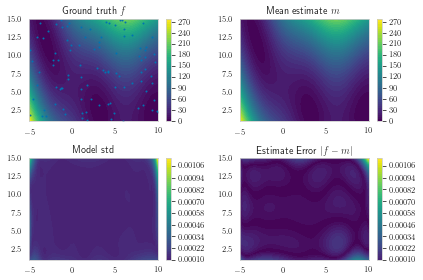

In [174]:
# Wrap for plotting
class WrapModel(object):
    X = train_x_np
    Y = train_y_np

    def get_statistics(self, X, full_cov=False):
        # Set model and likelihood into evaluation mode
        model.eval()
        likelihood.eval()

        test_x = torch.tensor(X).double()
        with torch.no_grad(), \
            gpytorch.settings.fast_computations(fast, fast, fast), \
            gpytorch.settings.fast_pred_var(fast):

            observed_pred = likelihood(model(test_x))
            pred_labels = observed_pred.mean
            pred_var = observed_pred.variance
            return pred_labels.detach().numpy(), pred_var.numpy()

wrap_model = WrapModel()

print(calc_errors(wrap_model, f, rand=True))
plot_model(wrap_model, f)
None

# Fix error calc
# Learn
# Try CG with double
# Try CG without dobule

In [179]:
X_line = random_hypercube_samples(2500, f.bounds, rng=np.random.RandomState(42))
Y_hat = wrap_model.get_statistics(X_line, full_cov=False)[0]
Y = f.noiseless(X_line)
Y_diff = Y - Y_hat
np.sqrt(np.sum(np.square(Y_diff)) / 2500)

3510.314819041811

In [175]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.detach().numpy()}')

Parameter name: likelihood.noise_covar.raw_noise           value = [-inf]
Parameter name: mean_module.constant                       value = [0.]
Parameter name: covar_module.raw_outputscale               value = 40.0
Parameter name: covar_module.base_kernel.raw_lengthscale   value = [[ 5.14888449 59.61978912]]


## GPy

In [115]:
from GPy.models import GPRegression

rng = np.random.RandomState(100)

f = Branin()
train_x_np = random_hypercube_samples(100, f.bounds, rng=rng)
train_y_np = f(train_x_np)

kernel = GPyRBF(2, ARD=True)
model = GPRegression(train_x_np, train_y_np, kernel=kernel)
model.optimize()

INFO - GP - initializing Y
INFO - GP - initializing inference method
INFO - GP - adding kernel and likelihood as parameters


In [116]:
#model.rbf.variance = 40
model.Gaussian_noise.variance = 1e-8

(0.020067991034488274, 0.4003884276067273)


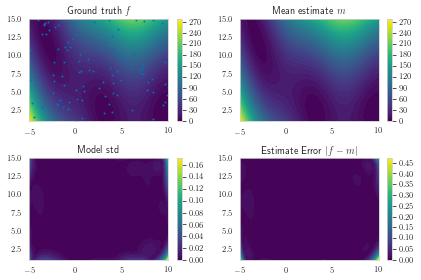

In [117]:
class WrapModel(object):
    X = train_x_np
    Y = train_y_np

    def get_statistics(self, X, full_cov=False):
        return model.predict(X)

wrap_model = WrapModel()

print(calc_errors(wrap_model, f, rand=True))
plot_model(wrap_model, f)
None

In [118]:
model

GP_regression.,value,constraints,priors
rbf.variance,5055.355881619578,+ve,
rbf.lengthscale,"(2,)",+ve,
Gaussian_noise.variance,1e-08,+ve,


In [119]:
model.rbf.lengthscale

index,GP_regression.rbf.lengthscale,constraints,priors
[0],3.37104651,+ve,
[1],8.72885148,+ve,


## CG

In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from explorer_helper import *

import numpy as np
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from gpytorch.likelihoods import GaussianLikelihood

rng = np.random.RandomState(99)

f = Branin()
train_x_np = random_hypercube_samples(1000, f.bounds, rng=rng)
train_y_np = f(train_x_np)[:, 0]
train_x = torch.tensor(train_x_np).double()
train_y = torch.tensor(train_y_np).double()

%matplotlib inline

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
                gpytorch.kernels.RBFKernel(ard_num_dims=2))

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
fast = False

likelihood = GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-8)).double()
model = GPRegressionModel(train_x, train_y, likelihood).double()

model.initialize(**{
    'covar_module.base_kernel.lengthscale': torch.tensor([5.15467336, 59.61979058]).double(),
    'covar_module.outputscale': 40,
    'likelihood.noise': 1e-8,
})

# Wrap for plotting
class WrapModel(object):
    X = train_x_np
    Y = train_y_np

    def get_statistics(self, X, full_cov=False):
        # Set model and likelihood into evaluation mode
        model.eval()
        likelihood.eval()

        test_x = torch.tensor(X).double()
        with torch.no_grad(), \
            gpytorch.settings.fast_computations(fast, fast, fast), \
            gpytorch.settings.fast_pred_var(fast):
        
            observed_pred = likelihood(model(test_x))
            pred_labels = observed_pred.mean
            pred_var = observed_pred.variance
            return pred_labels.detach().numpy()[:,None], pred_var.numpy()

wrap_model = WrapModel()

print(calc_errors(wrap_model, f, rand=True))
plot_model(wrap_model, f)
None

(11.34586328628679, 0.8127891680884591)


ValueError: cannot reshape array of size 6250000 into shape (50,50)

As N is increased CG iterations has to be increased (does tolerance also have to be increased?)

In [3]:
fast = True

likelihood = GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-8)).double()
model = GPRegressionModel(train_x, train_y, likelihood).double()

model.initialize(**{
    'covar_module.base_kernel.lengthscale': torch.tensor([5.15467336, 59.61979058]).double(),
    'covar_module.outputscale': 40,
    'likelihood.noise': 1e-8,
})

# Wrap for plotting
class WrapModel(object):
    X = train_x_np
    Y = train_y_np

    def get_statistics(self, X, full_cov=False):
        # Set model and likelihood into evaluation mode
        model.eval()
        likelihood.eval()

        test_x = torch.tensor(X).double()
        with torch.no_grad(), \
            gpytorch.settings.fast_computations(covar_root_decomposition=fast, log_prob=fast, solves=fast), \
            gpytorch.settings.fast_pred_var(fast),\
            gpytorch.settings.use_toeplitz(False), \
            gpytorch.settings.max_cg_iterations(2000),\
            gpytorch.settings.max_preconditioner_size(10),\
            gpytorch.settings.eval_cg_tolerance(0.00001):

            observed_pred = likelihood(model(test_x))
            pred_labels = observed_pred.mean
            pred_var = observed_pred.variance
            return pred_labels.detach().numpy()[:,None], pred_var.numpy()

wrap_model = WrapModel()

print(calc_errors(wrap_model, f, rand=True))
plot_model(wrap_model, f)
None

AttributeError: 'Branin' object has no attribute 'noiseless'

## IN lib

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WARNING - lions - No observers have been added to this run
INFO - lions - Running command 'main'
INFO - lions - Started
INFO - main - Model0: DKLGPModel training on 1000 of dim 2
INFO - main - Model0: DKLGPModel predicting on 2500 of dim 2
INFO - main - Model0: DKLGPModel has RMSE=0.0022277475692763695 max_err=0.01724186551623319
INFO - main - Model0 has parameters: {'outputscale': array(40.), 'lengthscale': array([[ 5.15467358, 59.61978912]]), 'noise': 9.999999883281411e-09}


{'lengthscale': [5.15467336, 59.61979058], 'noise': 1e-08, 'outputscale': 40}
training on 1000 data points of dim 2
predicting 2500 points using 1000 training points
predicting 2500 points using 1000 training points


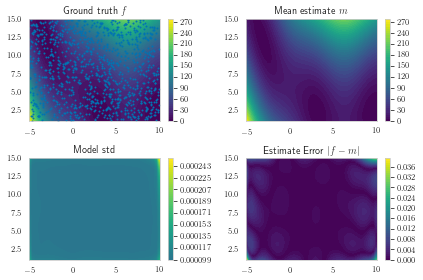

INFO - lions - Result: {'rmse': 0.0022277475692763695, 'max_err': 0.01724186551623319, 'time:training': 0.006401999999980035, 'time:pred': 0.5749250000000075, 'hyperparameters': {'outputscale': array(40.), 'lengthscale': array([[ 5.15467358, 59.61978912]]), 'noise': 9.999999883281411e-09}}
INFO - lions - Completed after 0:00:04


In [212]:
# Exact with GPyTorch
%matplotlib inline
%load_ext autoreload
%autoreload 2
import torch 
from explorer_helper import *

N = 1000

kissmodels = lambda N: {
            'name': 'DKLGPModel',
            'kwargs': {
                'learning_rate': 0.1,
                'n_iter': 0,
                'nn_kwargs': {'layers': None},
                'initial_parameters': {
                    'outputscale': 40, 
                    'lengthscale': [5.15467336, 59.61979058], 
                    'noise': 1e-8
                },
                'use_cg': False,
                'max_cg_iter': 1000,
                'precond_size': 0,
                'noise': None,
                'use_double_precision': True,
                'noise_lower_bound': 1e-10,
            }
        }

run = execute(config_updates={
    'obj_func': {
        'name': 'Branin',
    },
    'model': kissmodels(N),
    'gp_samples': N,
    #'use_sample_grid': True,
})


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WARNING - lions - No observers have been added to this run
INFO - lions - Running command 'main'
INFO - lions - Started
INFO - main - Model0: DKLGPModel training on 1000 of dim 2
INFO - main - Model0: DKLGPModel predicting on 2500 of dim 2
INFO - main - Model0: DKLGPModel has RMSE=0.002197508747625052 max_err=0.014662593722867712
INFO - main - Model0 has parameters: {'outputscale': array(40.), 'lengthscale': array([[ 5.15467358, 59.61978912]]), 'noise': 9.999999883281411e-09}


{'lengthscale': [5.15467336, 59.61979058], 'noise': 1e-08, 'outputscale': 40}
training on 1000 data points of dim 2
predicting 2500 points using 1000 training points
predicting 2500 points using 1000 training points


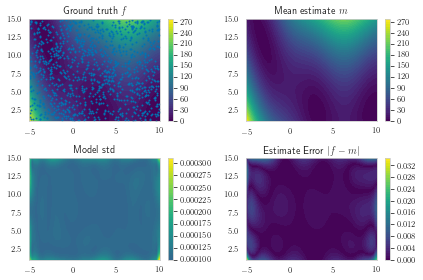

INFO - lions - Result: {'rmse': 0.002197508747625052, 'max_err': 0.014662593722867712, 'time:training': 0.006738000000041211, 'time:pred': 0.6243289999999888, 'hyperparameters': {'outputscale': array(40.), 'lengthscale': array([[ 5.15467358, 59.61978912]]), 'noise': 9.999999883281411e-09}}
INFO - lions - Completed after 0:00:01


In [76]:
# Exact using CG
%matplotlib inline
%load_ext autoreload
%autoreload 2

from explorer_helper import *

N = 1000

kissmodels = lambda N: {
            'name': 'DKLGPModel',
            'kwargs': {
                'learning_rate': 0.1,
                'n_iter': 0,
                'nn_kwargs': {'layers': None},
                'gp_kwargs': {'n_grid': None},
                'initial_parameters': {
                    'outputscale': 40, 
                    'lengthscale': [5.15467336, 59.61979058], 
                    'noise': 1e-8
                },
                'max_cg_iter': 1000,
                'precond_size': 10,
                'use_cg': True,
                'noise': None,
                'use_double_precision': True,
                'noise_lower_bound': 1e-10,
                'eval_cg_tolerance': 1e-5
            }
        }

run = execute(config_updates={
    'obj_func': {
        'name': 'Branin',
    },
    'model': kissmodels(N),
    'gp_samples': N,
    #'use_sample_grid': True,
})


## With KISS-GP

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WARNING - lions - No observers have been added to this run
INFO - lions - Running command 'main'
INFO - lions - Started
INFO - main - Model0: DKLGPModel training on 1000 of dim 2


training on 1000 data points of dim 2


INFO - dklgpmodel_training_callback - Iter 1/30 - Loss: 1174.751


Current hyperparameters: {'outputscale': array(0.6931472, dtype=float32), 'lengthscale': array([[0.6931472, 0.6931472]], dtype=float32), 'noise': 0.01}


INFO - dklgpmodel_training_callback - Iter 11/30 - Loss: 1005.056
INFO - dklgpmodel_training_callback - Iter 21/30 - Loss: 877.766
INFO - main - Model0: DKLGPModel predicting on 2500 of dim 2


predicting 2500 points using 1000 training points


INFO - main - Model0: DKLGPModel has RMSE=75.46280749299434 max_err=170.11306000075083
INFO - main - Model0 has parameters: {'outputscale': array(2.6263874, dtype=float32), 'lengthscale': array([[2.9538016, 2.1744955]], dtype=float32), 'noise': 0.01}


predicting 2500 points using 1000 training points


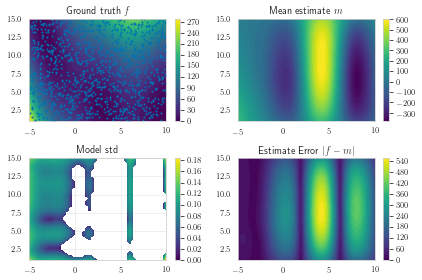

INFO - lions - Result: {'rmse': 75.46280749299434, 'max_err': 170.11306000075083, 'time:training': 46.00545299999976, 'time:pred': 84.22599400000036, 'hyperparameters': {'outputscale': array(2.6263874, dtype=float32), 'lengthscale': array([[2.9538016, 2.1744955]], dtype=float32), 'noise': 0.01}, 'WARNING': {'pred': True}}
INFO - lions - Completed after 0:00:32


In [132]:
# Exact using CG
%matplotlib inline
%load_ext autoreload
%autoreload 2

from explorer_helper import *

N = 1000

kissmodels = lambda N: {
            'name': 'DKLGPModel',
            'kwargs': {
                'learning_rate': 0.1,
                'n_iter': 30,
                'nn_kwargs': {'layers': None},
                'gp_kwargs': {'n_grid': 10},
                'max_cg_iter': 10000,
                'precond_size': 10,
                'use_cg': True,
                'noise': 0.01,
                'use_double_precision': False,
                'noise_lower_bound': 1e-10,
                'eval_cg_tolerance': 1e-10
            }
        }

run = execute(config_updates={
    'obj_func': {
        'name': 'Branin',
    },
    'model': kissmodels(N),
    'gp_samples': N,
    #'use_sample_grid': True,
})


## For Github issue

RMSE: 17.449121050946356


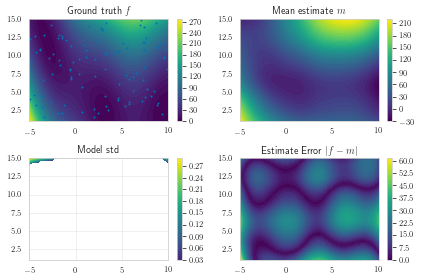

In [123]:
%matplotlib inline
import math

import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt
from gpytorch.likelihoods import GaussianLikelihood

# ---------------------------- Helpers ---------------------------------

class Branin(object):
    """Scrupulously stolen from GPyOpt and modified."""
    def __init__(self,bounds=None,a=None,b=None,c=None,r=None,s=None,t=None,sd=None):
        self.input_dim = 2
        if bounds is  None: self.bounds = np.array([(-5,10),(1,15)])
        else: self.bounds = bounds
        if a==None: self.a = 1
        else: self.a = a           
        if b==None: self.b = 5.1/(4*np.pi**2)
        else: self.b = b
        if c==None: self.c = 5/np.pi
        else: self.c = c
        if r==None: self.r = 6
        else: self.r = r
        if s==None: self.s = 10 
        else: self.s = s
        if t==None: self.t = 1/(8*np.pi)
        else: self.t = t    
        if sd==None: self.sd = 0
        else: self.sd=sd
        self.min = [(-np.pi,12.275),(np.pi,2.275),(9.42478,2.475)] 
        self.fmin = 0.397887
        self.name = 'Branin'
    
    def __call__(self,X):
        n = X.shape[0]
        if X.shape[1] != self.input_dim: 
            return 'Wrong input dimension'  
        else:
            x1 = X[:,0]
            x2 = X[:,1]
            fval = self.a * (x2 - self.b*x1**2 + self.c*x1 - self.r)**2 + self.s*(1-self.t)*np.cos(x1) + self.s 
            if self.sd ==0:
                noise = np.zeros(n).reshape(n,1)
            else:
                noise = np.random.normal(0,self.sd,n).reshape(n,1)
            return fval.reshape(n,1) + noise


def random_hypercube_samples(n_samples, bounds, rng=None):
    """Random sample from d-dimensional hypercube (d = bounds.shape[0]).

    Returns: (n_samples, dim)
    """
    if rng is None:
        rng = np.random.RandomState()

    dims = bounds.shape[0]
    a = rng.uniform(0, 1, (dims, n_samples))
    bounds_repeated = np.repeat(bounds[:, :, None], n_samples, axis=2)
    samples = a * np.abs(bounds_repeated[:,1] - bounds_repeated[:,0]) + bounds_repeated[:,0]
    samples = np.swapaxes(samples, 0, 1)

    # This handles the case where the sample is slightly above or below the bounds
    # due to floating point precision (leading to slightly more samples from the boundary...).
    return constrain_points(samples, bounds)


def constrain_points(x, bounds):
    dim = x.shape[0]
    minx = np.repeat(bounds[:, 0][None, :], dim, axis=0)
    maxx = np.repeat(bounds[:, 1][None, :], dim, axis=0)
    return np.clip(x, a_min=minx, a_max=maxx)


def plot2D(predict, f, X_train, Y_train):
    XY, X, Y = construct_2D_grid(f.bounds)

    # remove grid
    original_grid_size = XY.shape[0]
    XY = XY.reshape((-1, 2))

    mean, var = predict(XY)
    ground_truth = f(XY)

    # recreate grid
    mean = mean.reshape((original_grid_size, original_grid_size))
    var = var.reshape((original_grid_size, original_grid_size))
    ground_truth = ground_truth.reshape((original_grid_size, original_grid_size))

    fig = plt.figure()
    ax = fig.add_subplot(221)
    ax.set_title('Ground truth $f$')
    cont = ax.contourf(X, Y, ground_truth, 50)
    fig.colorbar(cont)
    ax.plot(X_train[:, 0], X_train[:, 1], '.', markersize=2)

    ax = fig.add_subplot(222)
    ax.set_title('Mean estimate $m$')
    cont = ax.contourf(X, Y, mean, 50)
    fig.colorbar(cont)
    # ax.plot(model.X[:, 0], model.X[:, 1], '.', markersize=10)

    ax = fig.add_subplot(223)
    ax.set_title('Model std')
    cont = ax.contourf(X, Y, np.sqrt(var), 50, vmin=0)
    fig.colorbar(cont)
    # ax.plot(model.X[:, 0], model.X[:, 1], '.', markersize=10)

    ax = fig.add_subplot(224)
    ax.set_title('Estimate Error $|f-m|$')
    cont = ax.contourf(X, Y, np.abs(mean - ground_truth), 50)
    fig.colorbar(cont)

    plt.tight_layout()

    return fig


def construct_2D_grid(bounds, N=2500):
    n = int(math.sqrt(N))
    x_bounds = bounds[0]
    y_bounds = bounds[1]
    X = np.linspace(x_bounds[0], x_bounds[1], n)
    Y = np.linspace(y_bounds[0], y_bounds[1], n)
    X, Y = np.meshgrid(X, Y)
    XY = np.stack((X,Y), axis=-1)

    return XY, X, Y

rng = np.random.RandomState(99)

f = Branin()
train_x_np = random_hypercube_samples(100, f.bounds, rng=rng)
train_y_np = f(train_x_np)[:, 0]
train_x = torch.tensor(train_x_np).double()
train_y = torch.tensor(train_y_np).double()

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(ard_num_dims=2),
                num_dims=2,
                grid_size=10,
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

fast = True

likelihood = GaussianLikelihood().double()
model = GPRegressionModel(train_x, train_y, likelihood).double()

model.initialize(**{
    'covar_module.base_kernel.base_kernel.lengthscale': torch.tensor([5, 8]).double(),
    'covar_module.outputscale': 8,
    'likelihood.noise': 1e-2,
})

def predict(X):
    # Set model and likelihood into evaluation mode
    model.eval()
    likelihood.eval()

    test_x = torch.tensor(X).double()
    with torch.no_grad(), \
        gpytorch.settings.fast_computations(covar_root_decomposition=True, log_prob=False, solves=True), \
        gpytorch.settings.fast_pred_var(True),\
        gpytorch.settings.use_toeplitz(True), \
        gpytorch.settings.max_cg_iterations(3000),\
        gpytorch.settings.max_preconditioner_size(20),\
        gpytorch.settings.eval_cg_tolerance(1e-8):

        observed_pred = likelihood(model(test_x))
        pred_labels = observed_pred.mean
        pred_var = observed_pred.variance
        return pred_labels.detach().numpy()[:,None], pred_var.detach().numpy()

plot2D(predict, f, train_x_np, train_y_np)

# Calculate RMSE
N = 2500
X_test = random_hypercube_samples(N, f.bounds)
Y_test = f(X_test)
Y_hat = predict(X_test)[0]
rmse = np.sqrt(np.sum(np.square(Y_test - Y_hat)) / N)
print("RMSE:", rmse)


In [ ]:
# grid bound M=10, N=100 => works

(2500, 1)
(2500, 1)
RMSE: 1535.9594372373351


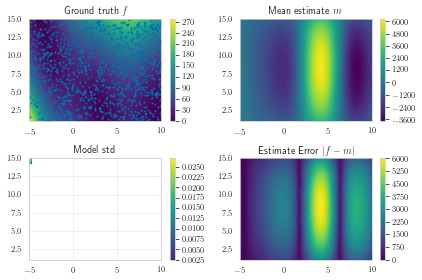

In [91]:
%matplotlib inline
import math

import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt
from gpytorch.likelihoods import GaussianLikelihood

# ---------------------------- Helpers ---------------------------------

class Branin(object):
    """Scrupulously stolen from GPyOpt and modified."""
    def __init__(self,bounds=None,a=None,b=None,c=None,r=None,s=None,t=None,sd=None):
        self.input_dim = 2
        if bounds is  None: self.bounds = np.array([(-5,10),(1,15)])
        else: self.bounds = bounds
        if a==None: self.a = 1
        else: self.a = a           
        if b==None: self.b = 5.1/(4*np.pi**2)
        else: self.b = b
        if c==None: self.c = 5/np.pi
        else: self.c = c
        if r==None: self.r = 6
        else: self.r = r
        if s==None: self.s = 10 
        else: self.s = s
        if t==None: self.t = 1/(8*np.pi)
        else: self.t = t    
        if sd==None: self.sd = 0
        else: self.sd=sd
        self.min = [(-np.pi,12.275),(np.pi,2.275),(9.42478,2.475)] 
        self.fmin = 0.397887
        self.name = 'Branin'
    
    def __call__(self,X):
        n = X.shape[0]
        if X.shape[1] != self.input_dim: 
            return 'Wrong input dimension'  
        else:
            x1 = X[:,0]
            x2 = X[:,1]
            fval = self.a * (x2 - self.b*x1**2 + self.c*x1 - self.r)**2 + self.s*(1-self.t)*np.cos(x1) + self.s 
            if self.sd ==0:
                noise = np.zeros(n).reshape(n,1)
            else:
                noise = np.random.normal(0,self.sd,n).reshape(n,1)
            return fval.reshape(n,1) + noise


def random_hypercube_samples(n_samples, bounds, rng=None):
    """Random sample from d-dimensional hypercube (d = bounds.shape[0]).

    Returns: (n_samples, dim)
    """
    if rng is None:
        rng = np.random.RandomState()

    dims = bounds.shape[0]
    a = rng.uniform(0, 1, (dims, n_samples))
    bounds_repeated = np.repeat(bounds[:, :, None], n_samples, axis=2)
    samples = a * np.abs(bounds_repeated[:,1] - bounds_repeated[:,0]) + bounds_repeated[:,0]
    samples = np.swapaxes(samples, 0, 1)

    # This handles the case where the sample is slightly above or below the bounds
    # due to floating point precision (leading to slightly more samples from the boundary...).
    return constrain_points(samples, bounds)


def constrain_points(x, bounds):
    dim = x.shape[0]
    minx = np.repeat(bounds[:, 0][None, :], dim, axis=0)
    maxx = np.repeat(bounds[:, 1][None, :], dim, axis=0)
    return np.clip(x, a_min=minx, a_max=maxx)


def plot2D(predict, f, X_train, Y_train):
    XY, X, Y = construct_2D_grid(f.bounds)

    # remove grid
    original_grid_size = XY.shape[0]
    XY = XY.reshape((-1, 2))

    mean, var = predict(XY)
    ground_truth = f(XY)

    # recreate grid
    mean = mean.reshape((original_grid_size, original_grid_size))
    var = var.reshape((original_grid_size, original_grid_size))
    ground_truth = ground_truth.reshape((original_grid_size, original_grid_size))

    fig = plt.figure()
    ax = fig.add_subplot(221)
    ax.set_title('Ground truth $f$')
    cont = ax.contourf(X, Y, ground_truth, 50)
    fig.colorbar(cont)
    ax.plot(X_train[:, 0], X_train[:, 1], '.', markersize=2)

    ax = fig.add_subplot(222)
    ax.set_title('Mean estimate $m$')
    cont = ax.contourf(X, Y, mean, 50)
    fig.colorbar(cont)
    # ax.plot(model.X[:, 0], model.X[:, 1], '.', markersize=10)

    ax = fig.add_subplot(223)
    ax.set_title('Model std')
    cont = ax.contourf(X, Y, np.sqrt(var), 50, vmin=0)
    fig.colorbar(cont)
    # ax.plot(model.X[:, 0], model.X[:, 1], '.', markersize=10)

    ax = fig.add_subplot(224)
    ax.set_title('Estimate Error $|f-m|$')
    cont = ax.contourf(X, Y, np.abs(mean - ground_truth), 50)
    fig.colorbar(cont)

    plt.tight_layout()

    return fig


def construct_2D_grid(bounds, N=2500):
    n = int(math.sqrt(N))
    x_bounds = bounds[0]
    y_bounds = bounds[1]
    X = np.linspace(x_bounds[0], x_bounds[1], n)
    Y = np.linspace(y_bounds[0], y_bounds[1], n)
    X, Y = np.meshgrid(X, Y)
    XY = np.stack((X,Y), axis=-1)

    return XY, X, Y



rng = np.random.RandomState(99)

f = Branin()
train_x_np = random_hypercube_samples(1000, f.bounds, rng=rng)
train_y_np = f(train_x_np)[:, 0]
train_x = torch.tensor(train_x_np).float()
train_y = torch.tensor(train_y_np).float()

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(ard_num_dims=2),
                num_dims=2,
                grid_size=10,
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

fast = True

likelihood = GaussianLikelihood().float()
model = GPRegressionModel(train_x, train_y, likelihood).float()

model.initialize(**{
    'covar_module.base_kernel.base_kernel.lengthscale': torch.tensor([5.0, 60.0]).float(),
    'covar_module.outputscale': 40,
    'likelihood.noise': 1e-4,
})

def predict(X):
    # Set model and likelihood into evaluation mode
    model.eval()
    likelihood.eval()

    test_x = torch.tensor(X).float()
    with torch.no_grad(), \
        gpytorch.settings.fast_computations(covar_root_decomposition=fast, log_prob=fast, solves=fast), \
        gpytorch.settings.fast_pred_var(fast),\
        gpytorch.settings.use_toeplitz(True), \
        gpytorch.settings.max_cg_iterations(3000),\
        gpytorch.settings.max_preconditioner_size(20),\
        gpytorch.settings.eval_cg_tolerance(1e-8):

        observed_pred = likelihood(model(test_x))
        pred_labels = observed_pred.mean
        pred_var = observed_pred.variance
        mean = pred_labels.contiguous().detach().numpy()[:,None]
        print(mean.shape)
        return mean, pred_var.detach().numpy()

plot2D(predict, f, train_x_np, train_y_np)

# Calculate RMSE
N = 2500
X_test = random_hypercube_samples(N, f.bounds)
Y_test = f(X_test)
Y_hat = predict(X_test)[0]
rmse = np.sqrt(np.sum(np.square(Y_test - Y_hat)) / N)
print("RMSE:", rmse)


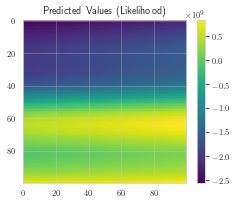

In [73]:
n = 100
test_x, _, _ = construct_2D_grid(f.bounds, N=n**2)
test_x = np.reshape(test_x, (-1, 2))
test_x = torch.tensor(test_x).float()

model.eval()
likelihood.eval()

with torch.no_grad(), \
    gpytorch.settings.fast_computations(covar_root_decomposition=fast, log_prob=fast, solves=fast), \
    gpytorch.settings.fast_pred_var(fast),\
    gpytorch.settings.use_toeplitz(True), \
    gpytorch.settings.max_cg_iterations(3000),\
    gpytorch.settings.max_preconditioner_size(20),\
    gpytorch.settings.eval_cg_tolerance(1e-8):

    observed_pred = likelihood(model(test_x))
    pred_labels = observed_pred.mean
    pred_labels = pred_labels.view(n, n)


# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Plot our predictive means
fig, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(fig, observed_ax, pred_labels, 'Predicted Values (Likelihood)')


## Learning Sinc2D

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


WARNING - lions - No observers have been added to this run
INFO - lions - Running command 'main'
INFO - lions - Started
INFO - main - Model0: DKLGPModel training on 1000 of dim 2
INFO - dklgpmodel_training_callback - Iter 1/100 - Loss: 1.034


training on 1000 data points of dim 2
Current hyperparameters: {'outputscale': array(0.69314718), 'lengthscale': array([[0.69314718, 0.69314718]]), 'noise': 0.6932471805574191}


INFO - dklgpmodel_training_callback - Iter 11/100 - Loss: 0.562
INFO - dklgpmodel_training_callback - Iter 21/100 - Loss: 0.032
INFO - dklgpmodel_training_callback - Iter 31/100 - Loss: -0.482


Current hyperparameters: {'outputscale': array(0.06423726), 'lengthscale': array([[2.94622253, 2.94031108]]), 'noise': 0.04154450458638872}


INFO - dklgpmodel_training_callback - Iter 41/100 - Loss: -0.944
INFO - dklgpmodel_training_callback - Iter 51/100 - Loss: -1.372
INFO - dklgpmodel_training_callback - Iter 61/100 - Loss: -1.758


Current hyperparameters: {'outputscale': array(0.02332367), 'lengthscale': array([[2.47118677, 2.45762938]]), 'noise': 0.0018304601395995085}


INFO - dklgpmodel_training_callback - Iter 71/100 - Loss: -2.071
INFO - dklgpmodel_training_callback - Iter 81/100 - Loss: -2.332
INFO - dklgpmodel_training_callback - Iter 91/100 - Loss: -2.503


Current hyperparameters: {'outputscale': array(0.02341521), 'lengthscale': array([[2.90818195, 2.89975902]]), 'noise': 0.0002179587781696911}


INFO - main - Model0: DKLGPModel predicting on 2500 of dim 2


predicting 2500 points using 1000 training points


INFO - main - Model0: DKLGPModel has RMSE=0.002899527061002289 max_err=0.018538623867545033
INFO - main - Model0 has parameters: {'outputscale': array(0.03301446), 'lengthscale': array([[3.16777938, 3.17307321]]), 'noise': 0.00016382420405229104}


predicting 2500 points using 1000 training points


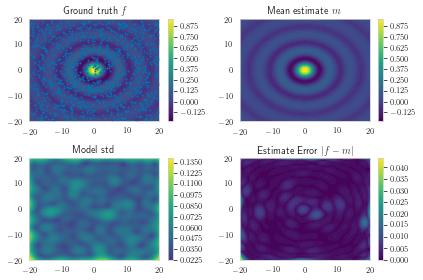

INFO - lions - Result: {'rmse': 0.002899527061002289, 'max_err': 0.018538623867545033, 'time:training': 50.944165999999996, 'time:pred': 1.6694070000000352, 'hyperparameters': {'outputscale': array(0.03301446), 'lengthscale': array([[3.16777938, 3.17307321]]), 'noise': 0.00016382420405229104}}
INFO - lions - Completed after 0:00:10


In [15]:
# Exact using CG
%matplotlib inline
%load_ext autoreload
%autoreload 2

from explorer_helper import *

N = 1000

kissmodels = lambda N: {
            'name': 'DKLGPModel',
            'kwargs': {
                'learning_rate': 0.1,
                'n_iter': 100,
                'nn_kwargs': {'layers': None},
                'gp_kwargs': {'n_grid': None},
                'max_cg_iter': 1000,
                'precond_size': 10,
                'use_cg': True,
                'noise': None,
                'use_double_precision': True,
                'noise_lower_bound': 1e-10,
                'eval_cg_tolerance': 1e-5
            }
        }

run = execute(config_updates={
    'obj_func': {
        'name': 'Sinc2D',
    },
    'model': kissmodels(N),
    'gp_samples': N,
    #'use_sample_grid': True,
})


## Working Tutorial

torch.Size([1600, 1])

In [29]:
torch.zeros(pow(n, 2), 2)

tensor([[0., 0.],
        [0., 0.],
        [0., 0.],
        ...,
        [0., 0.],
        [0., 0.],
        [0., 0.]])

In [77]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

f = Branin()

%matplotlib inline

n = 40
#train_x = torch.tensor(random_hypercube_samples(n**2, f.bounds)).float()
# True function is sin( 2*pi*(x0+x1))
#train_y = torch.tensor(f(train_x.numpy()))[:,0].float()

train_x_np = random_hypercube_samples(1000, f.bounds, rng=rng)
train_y_np = f(train_x_np)[:, 0]
train_x = torch.tensor(train_x_np).float()
train_y = torch.tensor(train_y_np).float()


class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(ard_num_dims=2),
                grid_size=10, num_dims=2
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train():
    training_iterations = 30
    for i in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.item()))
        optimizer.step()

%time train()


Iter 1/30 - Loss: 207.289
Iter 2/30 - Loss: 193.098
Iter 3/30 - Loss: 180.194
Iter 4/30 - Loss: 168.454
Iter 5/30 - Loss: 157.755
Iter 6/30 - Loss: 147.944
Iter 7/30 - Loss: 138.901
Iter 8/30 - Loss: 130.484
Iter 9/30 - Loss: 122.565
Iter 10/30 - Loss: 115.033
Iter 11/30 - Loss: 107.802
Iter 12/30 - Loss: 100.828
Iter 13/30 - Loss: 94.080
Iter 14/30 - Loss: 87.591
Iter 15/30 - Loss: 81.397
Iter 16/30 - Loss: 75.569
Iter 17/30 - Loss: 70.151
Iter 18/30 - Loss: 65.210
Iter 19/30 - Loss: 60.764
Iter 20/30 - Loss: 56.815
Iter 21/30 - Loss: 53.349
Iter 22/30 - Loss: 50.335
Iter 23/30 - Loss: 47.729
Iter 24/30 - Loss: 45.485
Iter 25/30 - Loss: 43.556
Iter 26/30 - Loss: 41.895
Iter 27/30 - Loss: 40.463
Iter 28/30 - Loss: 39.218
Iter 29/30 - Loss: 38.137
Iter 30/30 - Loss: 37.188
CPU times: user 39.5 s, sys: 7.18 s, total: 46.6 s
Wall time: 7.78 s


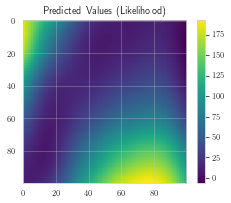

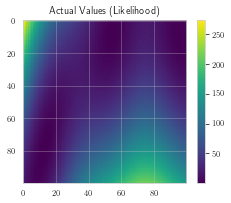

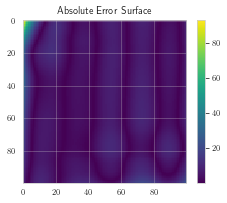

In [78]:
# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

# Generate nxn grid of test points spaced on a grid of size 1/(n-1) in [0,1]x[0,1]
n = 100
test_x, _, _ = construct_2D_grid(f.bounds, N=n**2)
test_x = np.reshape(test_x, (-1, 2))
test_x = torch.tensor(test_x).float()

with torch.no_grad(), \
    gpytorch.settings.fast_pred_var(True),\
    gpytorch.settings.fast_computations(covar_root_decomposition=True, log_prob=True, solves=True), \
    gpytorch.settings.use_toeplitz(True), \
    gpytorch.settings.max_cg_iterations(1000),\
    gpytorch.settings.max_preconditioner_size(10),\
    gpytorch.settings.eval_cg_tolerance(1e-8):
    
    observed_pred = likelihood(model(test_x))
    pred_labels = observed_pred.mean.view(n, n)

# Calc abosolute error
test_y_actual = torch.tensor(f(test_x.numpy()))[:,0].float().view(n, n)
delta_y = torch.abs(pred_labels - test_y_actual).detach().numpy()

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Plot our predictive means
fig, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(fig, observed_ax, pred_labels, 'Predicted Values (Likelihood)')

# Plot the true values
fig, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(fig, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

# Plot the absolute errors
fig, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(fig, observed_ax3, delta_y, 'Absolute Error Surface')


In [79]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.detach().numpy()}')

Parameter name: likelihood.noise_covar.raw_noise           value = [2.265516]
Parameter name: covar_module.raw_outputscale               value = 2.2375776767730713
Parameter name: covar_module.base_kernel.base_kernel.raw_lengthscale value = [[2.8840418 2.7172666]]


## Tutorial modified

In [83]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt

f = Branin()

%matplotlib inline

n = 40
#train_x = torch.tensor(random_hypercube_samples(n**2, f.bounds)).float()
# True function is sin( 2*pi*(x0+x1))
#train_y = torch.tensor(f(train_x.numpy()))[:,0].float()

train_x_np = random_hypercube_samples(1000, f.bounds, rng=rng)
train_y_np = f(train_x_np)[:, 0]
train_x = torch.tensor(train_x_np).float()
train_y = torch.tensor(train_y_np).float()


class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        # SKI requires a grid size hyperparameter. This util can help with that

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(ard_num_dims=2),
                grid_size=10, num_dims=2
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)


likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPRegressionModel(train_x, train_y, likelihood)

model.initialize(**{
    'covar_module.base_kernel.base_kernel.lengthscale': torch.tensor([5.15467336, 59.61979058]).float(),
    'covar_module.outputscale': 40,
    'likelihood.noise': 1e-4,
})

GPRegressionModel(
  (likelihood): GaussianLikelihood(
    (quadrature): GaussHermiteQuadrature1D()
    (noise_covar): HomoskedasticNoise(
      (raw_noise_constraint): GreaterThan(1.000E-04)
    )
  )
  (mean_module): ZeroMean()
  (covar_module): ScaleKernel(
    (base_kernel): GridInterpolationKernel(
      (base_kernel): RBFKernel(
        (raw_lengthscale_constraint): Positive()
      )
    )
    (raw_outputscale_constraint): Positive()
  )
)

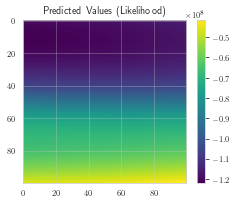

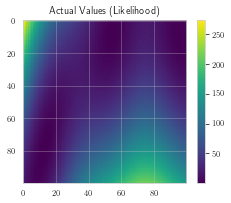

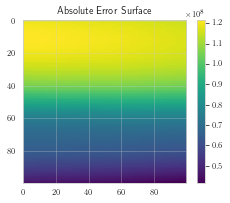

In [84]:
# Set model and likelihood into evaluation mode
model.eval()
likelihood.eval()

# Generate nxn grid of test points spaced on a grid of size 1/(n-1) in [0,1]x[0,1]
n = 100
test_x, _, _ = construct_2D_grid(f.bounds, N=n**2)
test_x = np.reshape(test_x, (-1, 2))
test_x = torch.tensor(test_x).float()

with torch.no_grad(), \
    gpytorch.settings.fast_pred_var(True),\
    gpytorch.settings.fast_computations(covar_root_decomposition=True, log_prob=True, solves=True), \
    gpytorch.settings.use_toeplitz(True), \
    gpytorch.settings.max_cg_iterations(1000),\
    gpytorch.settings.max_preconditioner_size(10),\
    gpytorch.settings.eval_cg_tolerance(1e-8):
    
    observed_pred = likelihood(model(test_x))
    pred_labels = observed_pred.mean.view(n, n)

# Calc abosolute error
test_y_actual = torch.tensor(f(test_x.numpy()))[:,0].float().view(n, n)
delta_y = torch.abs(pred_labels - test_y_actual).detach().numpy()

# Define a plotting function
def ax_plot(f, ax, y_labels, title):
    im = ax.imshow(y_labels)
    ax.set_title(title)
    f.colorbar(im)

# Plot our predictive means
fig, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(fig, observed_ax, pred_labels, 'Predicted Values (Likelihood)')

# Plot the true values
fig, observed_ax2 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(fig, observed_ax2, test_y_actual, 'Actual Values (Likelihood)')

# Plot the absolute errors
fig, observed_ax3 = plt.subplots(1, 1, figsize=(4, 3))
ax_plot(fig, observed_ax3, delta_y, 'Absolute Error Surface')


In [61]:
for param_name, param in model.named_parameters():
    print(f'Parameter name: {param_name:42} value = {param.detach().numpy()}')

Parameter name: likelihood.noise_covar.raw_noise           value = [-inf]
Parameter name: covar_module.raw_outputscale               value = 40.0
Parameter name: covar_module.base_kernel.base_kernel.raw_lengthscale value = [[ 4.9932394 60.       ]]


## as

WARNING - lions - No observers have been added to this run
INFO - lions - Running command 'main'
INFO - lions - Started
INFO - main - Model0: NormalizerModel training on 2500 of dim 2
INFO - main - Model0: NormalizerModel predicting on 2500 of dim 2


{'lengthscale': [1, 4], 'noise': 3.6095492946864014e-07, 'outputscale': [5.94259908]}
training on 2500 data points of dim 2
predicting 2500 points using 2500 training points


INFO - main - Model0: NormalizerModel has RMSE=1879310.7679228121 max_err=6158413.302166511
INFO - main - Model0 has parameters: {'outputscale': array(5.9425993), 'lengthscale': array([[1., 4.]]), 'noise': 3.6095494232395383e-07}


predicting 2500 points using 2500 training points


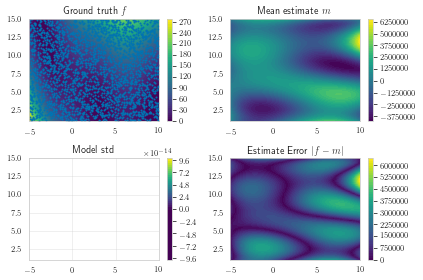

INFO - lions - Result: {'rmse': 1879310.7679228121, 'max_err': 6158413.302166511, 'time:training': 0.010929000000032829, 'time:pred': 57.43446500000027, 'hyperparameters': {'outputscale': array(5.9425993), 'lengthscale': array([[1., 4.]]), 'noise': 3.6095494232395383e-07}, 'WARNING': {'pred': True}}
INFO - lions - Completed after 0:00:26


In [156]:
# CG with GPyTorch

N = 50

gp = {
    'name': 'NormalizerModel',
    'kwargs': {
        'model': {
            'name': 'DKLGPModel',
            'kwargs': {
                'learning_rate': 0.1,
                'n_iter': 0,
                'nn_kwargs': {'layers': None},
                'gp_kwargs': {'n_grid': 50},
                'max_cg_iter': 3000,
                'precond_size': 20,
                'use_cg': True,
                'noise': None,
                'use_double_precision': True,
                'noise_lower_bound': 1e-10,
                'eval_cg_tolerance': 1e-9,
                'initial_parameters': {
                    'outputscale': [5.94259908],
                    'lengthscale': [1, 4],
                    'noise': 3.6095492946864014e-07}
            }
        }
    }
}
    
run = execute(config_updates={
    'tag': 'scalable-smooth',
    'obj_func': {
        'name': 'Branin',
    },
    'model': gp,
    'gp_samples': N ** 2,
})

In [144]:
run.interactive_stash.model.model.get_common_hyperparameters()

{'outputscale': array(5.94259908),
 'lengthscale': array([[5.37103432, 1.14762312]]),
 'noise': 3.6095492946864014e-07}

In [150]:
run.interactive_stash.model.model.get_common_hyperparameters()

{'outputscale': array(4.44246753),
 'lengthscale': array([[1.09400922, 4.68887424]]),
 'noise': 3.985645145865336e-07}

## RFF

In [2]:
Ms = [5000]

for M in Ms:
    run = execute(config_updates={
        'tag': 'natural_sound',
        'obj_func': {
            'name': 'NaturalSound',
            'kwargs': {},
        },
        'model': {
            'name': 'DKLGPModel',
            'kwargs': {
                'learning_rate': 0.1,
                'n_iter': 100,
                'nn_kwargs': {'layers': None},
                'gp_kwargs': {'n_grid': M},
                'max_cg_iter': 1500,
                'precond_size': 10,
                'use_cg': True,
                'noise': None
            }
        }
    })

WARNING - lions - No observers have been added to this run
INFO - lions - Running command 'main'
INFO - lions - Started
INFO - main - Model0: DKLGPModel training on 59309 of dim 1


training on 59309 data points of dim 1


INFO - dklgpmodel_training_callback - Iter 1/100 - Loss: 0.835


Current hyperparameters: {'outputscale': array(0.6931472, dtype=float32), 'lengthscale': array([[0.6931472]], dtype=float32), 'noise': 0.6932471990585327}


WARNING - lions - Aborted after 0:00:17!


KeyboardInterrupt: 

WARNING - lions - No observers have been added to this run
INFO - lions - Running command 'main'
INFO - lions - Started
INFO - main - Model0: SSGP training on 2000 of dim 1
INFO - main - Model0: SSGP predicting on 691 of dim 1


2000
{'lengthscale': 0.6931472, 'noise': 1.826772204367444e-06, 'variance': [0.00194766]}
training on 2000 data points of dim 1
predicting 691 points using 2000 training points


INFO - main - Model0: SSGP has RMSE=0.16603554714461982 max_err=0.566902454949218


predicting 1000 points using 2000 training points


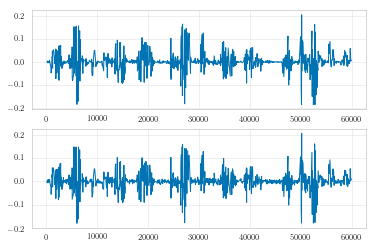

INFO - lions - Result: {'rmse': 0.16603554714461982, 'max_err': 0.566902454949218, 'time:training': 0.0053339999999479915, 'time:pred': 33.13581399999998, 'WARNING': {'pred': True}}
INFO - lions - Completed after 0:00:09


In [80]:

Ms = [2000]

for M in Ms:
    run = execute(config_updates={
        'tag': 'natural_sound',
        'obj_func': {
            'name': 'NaturalSound',
            'kwargs': {'subset_size': 2000},
        },
        'model': {
            'name': 'SSGP',
            'kwargs': {
                'learning_rate': 0.1,
                'feature_extractor_constructor': {
                    'name': 'RFFEmbedding',
                    'kwargs': {
                        'M': M,
                        'optimize_spectral_points': True,
                    }
                },
                'initial_parameters': {
                    'variance': [0.00194766], 
                    'lengthscale': 0.6931472, 
                    'noise': 0.000001826772204367444
                },
                'n_iter': 0,
                'max_cg_iter': 2500,
                'precond_size': 10,
                'use_cg': True,
                'use_double_precision': True,
                'noise_lower_bound': 1e-10,
                'eval_cg_tolerance': 1e-10,
                'noise': None
            }
        }
    })

WARNING - lions - No observers have been added to this run
INFO - lions - Running command 'main'
INFO - lions - Started
INFO - main - Model0: SSGP training on 100 of dim 1


{'lengthscale': 0.6931472, 'noise': 0.0001826772204367444, 'variance': [0.00194766]}
training on 100 data points of dim 1
Current hyperparameters: {'lengthscale': array([0.6931472]), 'variance': tensor([[0.0019]], dtype=torch.float64, grad_fn=<SoftplusBackward>), 'noise': 0.00018267722043681562}
Iter 1/300 - Loss: 1.971
Iter 21/300 - Loss: -2.267
Current hyperparameters: {'lengthscale': array([1.09120974]), 'variance': tensor([[0.0142]], dtype=torch.float64, grad_fn=<SoftplusBackward>), 'noise': 3.0379836907332842e-05}
Iter 41/300 - Loss: -3.461
Current hyperparameters: {'lengthscale': array([1.29492123]), 'variance': tensor([[0.0247]], dtype=torch.float64, grad_fn=<SoftplusBackward>), 'noise': 1.3659900587727588e-06}
Iter 61/300 - Loss: -4.278
Iter 81/300 - Loss: -5.049
Current hyperparameters: {'lengthscale': array([1.41852327]), 'variance': tensor([[0.0310]], dtype=torch.float64, grad_fn=<SoftplusBackward>), 'noise': 6.307122625061177e-08}
Iter 101/300 - Loss: -6.124
Current hyperpa

INFO - main - Model0: SSGP predicting on 2500 of dim 1


{'lengthscale': array([1.69539878]), 'variance': tensor([[0.0529]], dtype=torch.float64, grad_fn=<SoftplusBackward>), 'noise': 1.0877016060237173e-10}
Iter 241/300 - Loss: -8.147
Iter 261/300 - Loss: -8.586
Current hyperparameters: {'lengthscale': array([1.78833639]), 'variance': tensor([[0.0566]], dtype=torch.float64, grad_fn=<SoftplusBackward>), 'noise': 1.0630042192823895e-10}
Iter 281/300 - Loss: -8.521
predicting 2500 points using 100 training points


INFO - main - Model0: SSGP has RMSE=2.7392258063587555e-06 max_err=2.5802991530009256e-05


predicting 100 points using 100 training points


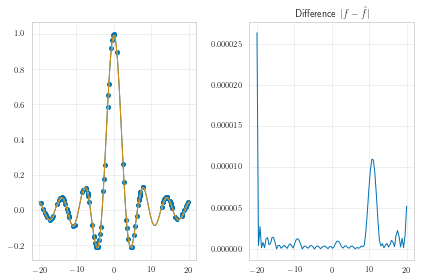

INFO - lions - Result: {'rmse': 2.7392258063587555e-06, 'max_err': 2.5802991530009256e-05, 'time:training': 7.053667000000132, 'time:pred': 0.08675399999992806}
INFO - lions - Completed after 0:00:02


In [62]:
    run = execute(config_updates={
        'obj_func': {
            'name': 'Sinc',
            'kwargs': {},
        },
        'model': {
            'name': 'SSGP',
            'kwargs': {
                'n_iter': 300,
                'learning_rate': 0.1,
                'feature_extractor_constructor': {
                    'name': 'RFFEmbedding',
                    'kwargs': {
                        'M': 100,
                        'ARD': False,
                        'optimize_spectral_points': True,
                    }
                },
                'initial_parameters': {
                    'variance': [0.00194766], 
                    'lengthscale': 0.6931472, 
                    'noise': 0.0001826772204367444
                },
                'max_cg_iter': 1500,
                'precond_size': 10,
                'use_cg': True,
                'use_double_precision': True,
                'noise_lower_bound': 1e-10,
                'eval_cg_tolerance': 1e-8,
                'noise': None
            }
        },
        'gp_samples': 100
    })

/Users/tmpethick/anaconda3/envs/lions/lib/python3.6/site-packages/gpytorch/utils/linear_cg.py:295: UserWarning: CG terminated in 9000 iterations with average residual norm 11764.69084926893 which is larger than the tolerance of 0.001 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


RMSE: 867359.1443212415


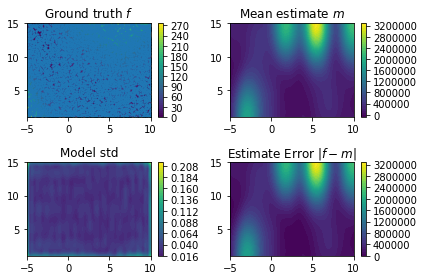

In [26]:
import math

import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt
from gpytorch.likelihoods import GaussianLikelihood

# ---------------------------- Helpers ---------------------------------

class Branin(object):
    """Scrupulously stolen from GPyOpt and modified."""
    def __init__(self,bounds=None,a=None,b=None,c=None,r=None,s=None,t=None,sd=None):
        self.input_dim = 2
        if bounds is  None: self.bounds = np.array([(-5,10),(1,15)])
        else: self.bounds = bounds
        if a==None: self.a = 1
        else: self.a = a           
        if b==None: self.b = 5.1/(4*np.pi**2)
        else: self.b = b
        if c==None: self.c = 5/np.pi
        else: self.c = c
        if r==None: self.r = 6
        else: self.r = r
        if s==None: self.s = 10 
        else: self.s = s
        if t==None: self.t = 1/(8*np.pi)
        else: self.t = t    
        if sd==None: self.sd = 0
        else: self.sd=sd
        self.min = [(-np.pi,12.275),(np.pi,2.275),(9.42478,2.475)] 
        self.fmin = 0.397887
        self.name = 'Branin'
    
    def __call__(self,X):
        n = X.shape[0]
        if X.shape[1] != self.input_dim: 
            return 'Wrong input dimension'  
        else:
            x1 = X[:,0]
            x2 = X[:,1]
            fval = self.a * (x2 - self.b*x1**2 + self.c*x1 - self.r)**2 + self.s*(1-self.t)*np.cos(x1) + self.s 
            return fval.reshape(n,1)


def random_hypercube_samples(n_samples, bounds, rng=None):
    """Random sample from d-dimensional hypercube (d = bounds.shape[0]).

    Returns: (n_samples, dim)
    """
    if rng is None:
        rng = np.random.RandomState()

    dims = bounds.shape[0]
    a = rng.uniform(0, 1, (dims, n_samples))
    bounds_repeated = np.repeat(bounds[:, :, None], n_samples, axis=2)
    samples = a * np.abs(bounds_repeated[:,1] - bounds_repeated[:,0]) + bounds_repeated[:,0]
    samples = np.swapaxes(samples, 0, 1)

    # This handles the case where the sample is slightly above or below the bounds
    # due to doubleing point precision (leading to slightly more samples from the boundary...).
    return constrain_points(samples, bounds)


def constrain_points(x, bounds):
    dim = x.shape[0]
    minx = np.repeat(bounds[:, 0][None, :], dim, axis=0)
    maxx = np.repeat(bounds[:, 1][None, :], dim, axis=0)
    return np.clip(x, a_min=minx, a_max=maxx)


def plot2D(predict, f, X_train, Y_train):
    XY, X, Y = construct_2D_grid(f.bounds)

    # remove grid
    original_grid_size = XY.shape[0]
    XY = XY.reshape((-1, 2))

    mean, var = predict(XY)
    ground_truth = f(XY)

    # recreate grid
    mean = mean.reshape((original_grid_size, original_grid_size))
    var = var.reshape((original_grid_size, original_grid_size))
    ground_truth = ground_truth.reshape((original_grid_size, original_grid_size))

    fig = plt.figure()
    ax = fig.add_subplot(221)
    ax.set_title('Ground truth $f$')
    cont = ax.contourf(X, Y, ground_truth, 50)
    fig.colorbar(cont)
    ax.plot(X_train[:, 0], X_train[:, 1], '.', markersize=2)

    ax = fig.add_subplot(222)
    ax.set_title('Mean estimate $m$')
    cont = ax.contourf(X, Y, mean, 50)
    fig.colorbar(cont)
    # ax.plot(model.X[:, 0], model.X[:, 1], '.', markersize=10)

    ax = fig.add_subplot(223)
    ax.set_title('Model std')
    cont = ax.contourf(X, Y, np.sqrt(var), 50, vmin=0)
    fig.colorbar(cont)
    # ax.plot(model.X[:, 0], model.X[:, 1], '.', markersize=10)

    ax = fig.add_subplot(224)
    ax.set_title('Estimate Error $|f-m|$')
    cont = ax.contourf(X, Y, np.abs(mean - ground_truth), 50)
    fig.colorbar(cont)

    plt.tight_layout()

    return fig


def construct_2D_grid(bounds, N=2500):
    n = int(math.sqrt(N))
    x_bounds = bounds[0]
    y_bounds = bounds[1]
    X = np.linspace(x_bounds[0], x_bounds[1], n)
    Y = np.linspace(y_bounds[0], y_bounds[1], n)
    X, Y = np.meshgrid(X, Y)
    XY = np.stack((X,Y), axis=-1)

    return XY, X, Y
rng = np.random.RandomState(99)

f = Branin()
train_x_np = random_hypercube_samples(10000, f.bounds, rng=rng)
train_y_np = f(train_x_np)[:, 0]
train_x = torch.tensor(train_x_np).double()
train_y = torch.tensor(train_y_np).double()

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(ard_num_dims=2),
                num_dims=2,
                grid_size=140,
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

fast = True

likelihood = GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-5)).double()
model = GPRegressionModel(train_x, train_y, likelihood).double()

model.initialize(**{
    'covar_module.base_kernel.base_kernel.lengthscale': torch.tensor([4.1703322569216805, 1.0206230750199647]).double(),
    'covar_module.outputscale': 3.199482738277898,
    'likelihood.noise': 2.977149600649006e-05,
})

def predict(X):
    # Set model and likelihood into evaluation mode
    model.eval()
    likelihood.eval()

    test_x = torch.tensor(X).double()
    with torch.no_grad(), \
        gpytorch.settings.fast_computations(covar_root_decomposition=fast, log_prob=fast, solves=fast), \
        gpytorch.settings.fast_pred_var(fast),\
        gpytorch.settings.use_toeplitz(True), \
        gpytorch.settings.max_cg_iterations(3000),\
        gpytorch.settings.max_preconditioner_size(10),\
        gpytorch.settings.eval_cg_tolerance(1e-3):

        observed_pred = likelihood(model(test_x))
        pred_labels = observed_pred.mean
        pred_var = observed_pred.variance
        return pred_labels.detach().numpy()[:,None], pred_var.detach().numpy()

plot2D(predict, f, train_x_np, train_y_np)

# Calculate RMSE
N = 2500
X_test = random_hypercube_samples(N, f.bounds)
Y_test = f(X_test)
Y_hat = predict(X_test)[0]
rmse = np.sqrt(np.sum(np.square(Y_test - Y_hat)) / N)
print("RMSE:", rmse)

RMSE: 15.772071381672859


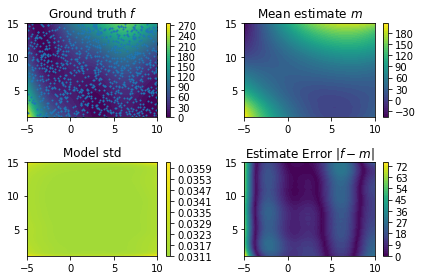

In [24]:
import math

import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt
from gpytorch.likelihoods import GaussianLikelihood

# ---------------------------- Helpers ---------------------------------

class Branin(object):
    """Scrupulously stolen from GPyOpt and modified."""
    def __init__(self,bounds=None,a=None,b=None,c=None,r=None,s=None,t=None,sd=None):
        self.input_dim = 2
        if bounds is  None: self.bounds = np.array([(-5,10),(1,15)])
        else: self.bounds = bounds
        if a==None: self.a = 1
        else: self.a = a           
        if b==None: self.b = 5.1/(4*np.pi**2)
        else: self.b = b
        if c==None: self.c = 5/np.pi
        else: self.c = c
        if r==None: self.r = 6
        else: self.r = r
        if s==None: self.s = 10 
        else: self.s = s
        if t==None: self.t = 1/(8*np.pi)
        else: self.t = t    
        if sd==None: self.sd = 0
        else: self.sd=sd
        self.min = [(-np.pi,12.275),(np.pi,2.275),(9.42478,2.475)] 
        self.fmin = 0.397887
        self.name = 'Branin'
    
    def __call__(self,X):
        n = X.shape[0]
        if X.shape[1] != self.input_dim: 
            return 'Wrong input dimension'  
        else:
            x1 = X[:,0]
            x2 = X[:,1]
            fval = self.a * (x2 - self.b*x1**2 + self.c*x1 - self.r)**2 + self.s*(1-self.t)*np.cos(x1) + self.s 
            return fval.reshape(n,1)


def random_hypercube_samples(n_samples, bounds, rng=None):
    """Random sample from d-dimensional hypercube (d = bounds.shape[0]).

    Returns: (n_samples, dim)
    """
    if rng is None:
        rng = np.random.RandomState()

    dims = bounds.shape[0]
    a = rng.uniform(0, 1, (dims, n_samples))
    bounds_repeated = np.repeat(bounds[:, :, None], n_samples, axis=2)
    samples = a * np.abs(bounds_repeated[:,1] - bounds_repeated[:,0]) + bounds_repeated[:,0]
    samples = np.swapaxes(samples, 0, 1)

    # This handles the case where the sample is slightly above or below the bounds
    # due to doubleing point precision (leading to slightly more samples from the boundary...).
    return constrain_points(samples, bounds)


def constrain_points(x, bounds):
    dim = x.shape[0]
    minx = np.repeat(bounds[:, 0][None, :], dim, axis=0)
    maxx = np.repeat(bounds[:, 1][None, :], dim, axis=0)
    return np.clip(x, a_min=minx, a_max=maxx)


def plot2D(predict, f, X_train, Y_train):
    XY, X, Y = construct_2D_grid(f.bounds)

    # remove grid
    original_grid_size = XY.shape[0]
    XY = XY.reshape((-1, 2))

    mean, var = predict(XY)
    ground_truth = f(XY)

    # recreate grid
    mean = mean.reshape((original_grid_size, original_grid_size))
    var = var.reshape((original_grid_size, original_grid_size))
    ground_truth = ground_truth.reshape((original_grid_size, original_grid_size))

    fig = plt.figure()
    ax = fig.add_subplot(221)
    ax.set_title('Ground truth $f$')
    cont = ax.contourf(X, Y, ground_truth, 50)
    fig.colorbar(cont)
    ax.plot(X_train[:, 0], X_train[:, 1], '.', markersize=2)

    ax = fig.add_subplot(222)
    ax.set_title('Mean estimate $m$')
    cont = ax.contourf(X, Y, mean, 50)
    fig.colorbar(cont)
    # ax.plot(model.X[:, 0], model.X[:, 1], '.', markersize=10)

    ax = fig.add_subplot(223)
    ax.set_title('Model std')
    cont = ax.contourf(X, Y, np.sqrt(var), 50, vmin=0)
    fig.colorbar(cont)
    # ax.plot(model.X[:, 0], model.X[:, 1], '.', markersize=10)

    ax = fig.add_subplot(224)
    ax.set_title('Estimate Error $|f-m|$')
    cont = ax.contourf(X, Y, np.abs(mean - ground_truth), 50)
    fig.colorbar(cont)

    plt.tight_layout()

    return fig


def construct_2D_grid(bounds, N=2500):
    n = int(math.sqrt(N))
    x_bounds = bounds[0]
    y_bounds = bounds[1]
    X = np.linspace(x_bounds[0], x_bounds[1], n)
    Y = np.linspace(y_bounds[0], y_bounds[1], n)
    X, Y = np.meshgrid(X, Y)
    XY = np.stack((X,Y), axis=-1)

    return XY, X, Y
rng = np.random.RandomState(99)

f = Branin()
train_x_np = random_hypercube_samples(10000, f.bounds, rng=rng)
train_y_np = f(train_x_np)[:, 0]
train_x = torch.tensor(train_x_np).double()
train_y = torch.tensor(train_y_np).double()

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.GridInterpolationKernel(
                gpytorch.kernels.RBFKernel(ard_num_dims=2),
                num_dims=2,
                grid_size=100,
            )
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

fast = True

likelihood = GaussianLikelihood().double()
model = GPRegressionModel(train_x, train_y, likelihood).double()

model.initialize(**{
    'covar_module.base_kernel.base_kernel.lengthscale': torch.tensor([5, 60]).double(),
    'covar_module.outputscale': 40,
    'likelihood.noise': 1e-4,
})

def predict(X):
    # Set model and likelihood into evaluation mode
    model.eval()
    likelihood.eval()

    test_x = torch.tensor(X).double()
    with torch.no_grad(), \
        gpytorch.settings.fast_computations(covar_root_decomposition=fast, log_prob=fast, solves=fast), \
        gpytorch.settings.fast_pred_var(fast),\
        gpytorch.settings.use_toeplitz(True), \
        gpytorch.settings.max_cg_iterations(30000),\
        gpytorch.settings.max_preconditioner_size(10),\
        gpytorch.settings.eval_cg_tolerance(1e-4):

        observed_pred = likelihood(model(test_x))
        pred_labels = observed_pred.mean
        pred_var = observed_pred.variance
        return pred_labels.detach().numpy()[:,None], pred_var.detach().numpy()

plot2D(predict, f, train_x_np, train_y_np)

# Calculate RMSE
N = 2500
X_test = random_hypercube_samples(N, f.bounds)
Y_test = f(X_test)
Y_hat = predict(X_test)[0]
rmse = np.sqrt(np.sum(np.square(Y_test - Y_hat)) / N)
print("RMSE:", rmse)

RMSE: 0.12343892474534213


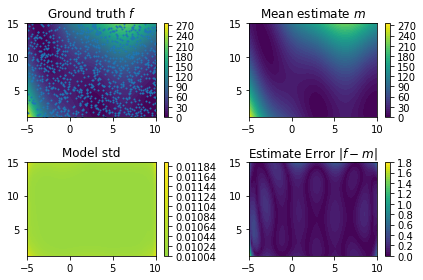

In [17]:
import math

import numpy as np
import torch
import gpytorch
from matplotlib import pyplot as plt
from gpytorch.likelihoods import GaussianLikelihood

# ---------------------------- Helpers ---------------------------------

class Branin(object):
    """Scrupulously stolen from GPyOpt and modified."""
    def __init__(self,bounds=None,a=None,b=None,c=None,r=None,s=None,t=None,sd=None):
        self.input_dim = 2
        if bounds is  None: self.bounds = np.array([(-5,10),(1,15)])
        else: self.bounds = bounds
        if a==None: self.a = 1
        else: self.a = a           
        if b==None: self.b = 5.1/(4*np.pi**2)
        else: self.b = b
        if c==None: self.c = 5/np.pi
        else: self.c = c
        if r==None: self.r = 6
        else: self.r = r
        if s==None: self.s = 10 
        else: self.s = s
        if t==None: self.t = 1/(8*np.pi)
        else: self.t = t    
        if sd==None: self.sd = 0
        else: self.sd=sd
        self.min = [(-np.pi,12.275),(np.pi,2.275),(9.42478,2.475)] 
        self.fmin = 0.397887
        self.name = 'Branin'
    
    def __call__(self,X):
        n = X.shape[0]
        if X.shape[1] != self.input_dim: 
            return 'Wrong input dimension'  
        else:
            x1 = X[:,0]
            x2 = X[:,1]
            fval = self.a * (x2 - self.b*x1**2 + self.c*x1 - self.r)**2 + self.s*(1-self.t)*np.cos(x1) + self.s 
            return fval.reshape(n,1)


def random_hypercube_samples(n_samples, bounds, rng=None):
    """Random sample from d-dimensional hypercube (d = bounds.shape[0]).

    Returns: (n_samples, dim)
    """
    if rng is None:
        rng = np.random.RandomState()

    dims = bounds.shape[0]
    a = rng.uniform(0, 1, (dims, n_samples))
    bounds_repeated = np.repeat(bounds[:, :, None], n_samples, axis=2)
    samples = a * np.abs(bounds_repeated[:,1] - bounds_repeated[:,0]) + bounds_repeated[:,0]
    samples = np.swapaxes(samples, 0, 1)

    # This handles the case where the sample is slightly above or below the bounds
    # due to floating point precision (leading to slightly more samples from the boundary...).
    return constrain_points(samples, bounds)


def constrain_points(x, bounds):
    dim = x.shape[0]
    minx = np.repeat(bounds[:, 0][None, :], dim, axis=0)
    maxx = np.repeat(bounds[:, 1][None, :], dim, axis=0)
    return np.clip(x, a_min=minx, a_max=maxx)


def plot2D(predict, f, X_train, Y_train):
    XY, X, Y = construct_2D_grid(f.bounds)

    # remove grid
    original_grid_size = XY.shape[0]
    XY = XY.reshape((-1, 2))

    mean, var = predict(XY)
    ground_truth = f(XY)

    # recreate grid
    mean = mean.reshape((original_grid_size, original_grid_size))
    var = var.reshape((original_grid_size, original_grid_size))
    ground_truth = ground_truth.reshape((original_grid_size, original_grid_size))

    fig = plt.figure()
    ax = fig.add_subplot(221)
    ax.set_title('Ground truth $f$')
    cont = ax.contourf(X, Y, ground_truth, 50)
    fig.colorbar(cont)
    ax.plot(X_train[:, 0], X_train[:, 1], '.', markersize=2)

    ax = fig.add_subplot(222)
    ax.set_title('Mean estimate $m$')
    cont = ax.contourf(X, Y, mean, 50)
    fig.colorbar(cont)
    # ax.plot(model.X[:, 0], model.X[:, 1], '.', markersize=10)

    ax = fig.add_subplot(223)
    ax.set_title('Model std')
    cont = ax.contourf(X, Y, np.sqrt(var), 50, vmin=0)
    fig.colorbar(cont)
    # ax.plot(model.X[:, 0], model.X[:, 1], '.', markersize=10)

    ax = fig.add_subplot(224)
    ax.set_title('Estimate Error $|f-m|$')
    cont = ax.contourf(X, Y, np.abs(mean - ground_truth), 50)
    fig.colorbar(cont)

    plt.tight_layout()

    return fig


def construct_2D_grid(bounds, N=2500):
    n = int(math.sqrt(N))
    x_bounds = bounds[0]
    y_bounds = bounds[1]
    X = np.linspace(x_bounds[0], x_bounds[1], n)
    Y = np.linspace(y_bounds[0], y_bounds[1], n)
    X, Y = np.meshgrid(X, Y)
    XY = np.stack((X,Y), axis=-1)

    return XY, X, Y
rng = np.random.RandomState(99)

f = Branin()
train_x_np = random_hypercube_samples(10000, f.bounds, rng=rng)
train_y_np = f(train_x_np)[:, 0]
train_x = torch.tensor(train_x_np).float()
train_y = torch.tensor(train_y_np).float()

class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)

        self.mean_module = gpytorch.means.ZeroMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.RBFKernel(ard_num_dims=2),
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

fast = True

likelihood = GaussianLikelihood().float()
model = GPRegressionModel(train_x, train_y, likelihood).float()

model.initialize(**{
    'covar_module.base_kernel.lengthscale': torch.tensor([5, 60]).float(),
    'covar_module.outputscale': 40,
    'likelihood.noise': 1e-4,
})

def predict(X):
    # Set model and likelihood into evaluation mode
    model.eval()
    likelihood.eval()

    test_x = torch.tensor(X).float()
    with torch.no_grad(), \
        gpytorch.settings.fast_computations(covar_root_decomposition=fast, log_prob=fast, solves=fast), \
        gpytorch.settings.fast_pred_var(fast),\
        gpytorch.settings.use_toeplitz(True), \
        gpytorch.settings.max_cg_iterations(9000),\
        gpytorch.settings.max_preconditioner_size(10),\
        gpytorch.settings.eval_cg_tolerance(1e-3):

        observed_pred = likelihood(model(test_x))
        pred_labels = observed_pred.mean
        pred_var = observed_pred.variance
        return pred_labels.detach().numpy()[:,None], pred_var.detach().numpy()

plot2D(predict, f, train_x_np, train_y_np)

# Calculate RMSE
N = 2500
X_test = random_hypercube_samples(N, f.bounds)
Y_test = f(X_test)
Y_hat = predict(X_test)[0]
rmse = np.sqrt(np.sum(np.square(Y_test - Y_hat)) / N)
print("RMSE:", rmse)